In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# 'cs231n' folder containing the '.py', 'classifiers' and 'datasets'
# folders.
# e.g. 'cs231n/assignments/assignment1/cs231n/'
FOLDERNAME = 'ML_Colab_CS231/assignment1/cs231n/'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd /content/drive/My\ Drive
# %cp -r $FOLDERNAME ../../
# %cd ../../
# %cd cs231n/datasets/
%cd $FOLDERNAME/datasets/
!bash get_datasets.sh
%cd ../../

Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive/ML_Colab_CS231/assignment1/cs231n/datasets
--2020-09-29 10:26:19--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  55.9MB/s    in 2.9s    

2020-09-29 10:26:22 (55.9 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content/drive/My Drive/ML_Colab_CS231/assignment1


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [ ]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [ ]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [6]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# learning_rates = []
# regularisation_strengths = []

valed_lrs = learning_rates  # np.logspace( np.log10(learning_rates[0]), np.log10(learning_rates[-1]), num=6)
valed_regs = regularization_strengths  # np.logspace( np.log10(regularisation_strengths[0]), np.log10(regularisation_strengths[-1]), num=6)

import itertools

for lr, reg in itertools.product(valed_lrs, valed_regs):
  svm = LinearSVM()
  svm.train(X_train_feats, y_train)
  train_acc = (svm.predict(X_train_feats) == y_train).mean()
  val_acc = (svm.predict(X_val_feats) == y_val).mean()

  results[(lr, reg)] = (train_acc, val_acc)
  
  if val_acc > best_val:
    best_val = val_acc
    best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.439592 val accuracy: 0.433000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.435041 val accuracy: 0.430000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.437224 val accuracy: 0.443000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.439735 val accuracy: 0.443000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.437918 val accuracy: 0.441000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.437776 val accuracy: 0.433000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.438510 val accuracy: 0.434000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.438612 val accuracy: 0.430000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.438143 val accuracy: 0.440000
best validation accuracy achieved during cross-validation: 0.443000


In [7]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.447


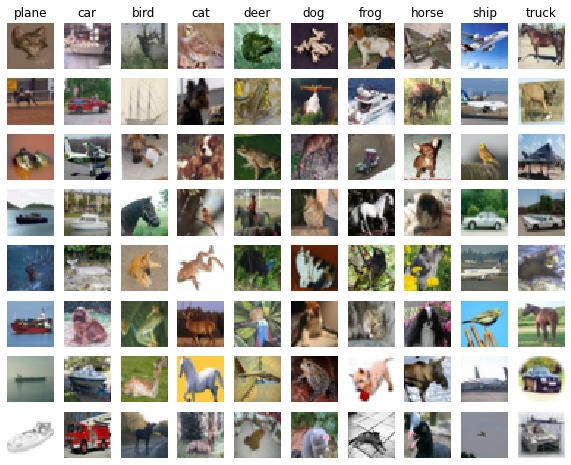

In [9]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$

No. Some of them are reasonable since the correct and incorrect class are so similar, like dog-cat or deer-horse or car-truck. Also in general all animals have similar backgrounds. But others like missclassifications between planes-ships are not and could have happened because they have a similar overall colour (blue background).

Even though we have transform our original raw pixels input space into an input space of orientation & color histograms per region, the original limitation of a linear classifer being able to learn only one template perists, and so in this new input space the class-separating boundaries are still linear and therefore we cannot account for traslational invariance, different camera perspectives, classes being possible in certain subsets of colours (cats can be orange, grey, black, white, black & white)... 


## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [ ]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

<< COMBI=1/1 ... HIDDEN_SIZE=400, LR=8.25e-01, REG=9.75e-04, BATCH_RATIO=0.004 ... BATCH_SIZE=200, NUM_ITERS=16000 >>
iteration 0 / 16000: loss 2.302586
iteration 245 / 16000: loss 1.406611
iteration 490 / 16000: loss 1.268627
iteration 735 / 16000: loss 1.165866
iteration 980 / 16000: loss 1.284812
iteration 1225 / 16000: loss 1.109448
iteration 1470 / 16000: loss 1.167599
iteration 1715 / 16000: loss 1.202213
iteration 1960 / 16000: loss 1.196108
iteration 2205 / 16000: loss 1.009983
iteration 2450 / 16000: loss 1.095680
iteration 2695 / 16000: loss 1.113813
iteration 2940 / 16000: loss 1.187983
iteration 3185 / 16000: loss 1.024883
iteration 3430 / 16000: loss 1.097221
iteration 3675 / 16000: loss 1.013036
iteration 3920 / 16000: loss 1.104562
iteration 4165 / 16000: loss 1.042869
iteration 4410 / 16000: loss 0.969784
iteration 4655 / 16000: loss 1.063093
iteration 4900 / 16000: loss 1.093899
iteration 5145 / 16000: loss 0.971204
iteration 5390 / 16000: loss 1.019178
iteration 5635 

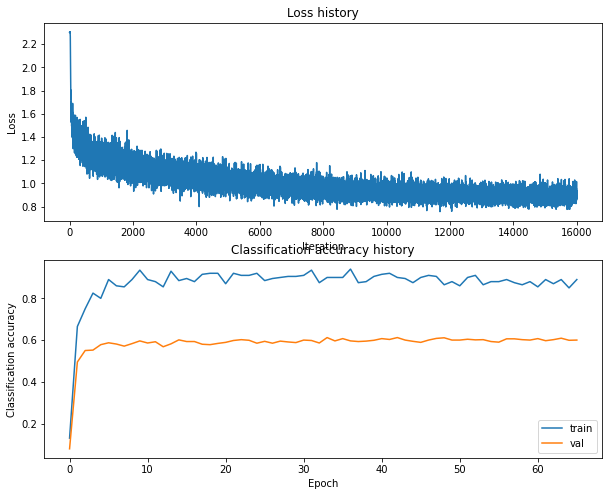

In [27]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

hidden_sizes = [100, 1000]
learning_rates = [1e-1, 3e0]
regs = [3e-4, 3e-3]
batch_epoch_ratio = [200/49000, 0.4]

valed_hidden_sizes = np.array([400])
#valed_lrs = np.logspace( np.log10(learning_rates[0]), np.log10(learning_rates[1]), num=5)
#valed_regs = np.logspace( np.log10(regs[0]), np.log10(regs[1]), num=5)
valed_lrs = np.array([8.25e-01])  # np.linspace( learning_rates[0], learning_rates[1], num=5)
valed_regs = np.array([9.75e-04])  # np.linspace(regs[0], regs[1], num=5)
valed_brs = np.array([200/49000])

import itertools

num_trains = X_train_feats.shape[0]
num_epochs = 16000*200/49000  # N.B. num_epochs * num_trains = batch_size * num_iters => num_epochs = br * num_iters

best_val_acc = -1
stats = None
results = {}

num_combinations = len(valed_hidden_sizes)*len(valed_lrs)*len(valed_regs)*len(valed_brs)
combi = 1

for hs, lr, reg, br in itertools.product(valed_hidden_sizes, valed_lrs, valed_regs, valed_brs):

  net = TwoLayerNet(input_dim, hs, num_classes)

  batch_size = np.around( br * num_trains ).astype(int)
  num_iters = np.around( num_epochs / br ).astype(int)

  print('<< COMBI=%d/%d ... HIDDEN_SIZE=%d, LR=%.2e, REG=%.2e, BATCH_RATIO=%.3f ... BATCH_SIZE=%d, NUM_ITERS=%d >>' \
        % (combi, num_combinations, hs, lr, reg, br,  batch_size, num_iters) )
  
  stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
              num_iters=num_iters, batch_size=batch_size,
              learning_rate=lr, learning_rate_decay=0.95,
              reg=reg, verbose=True)
  
  val_acc = (net.predict(X_val_feats) == y_val).mean()
  train_acc = (net.predict(X_train_feats) == y_train).mean()

  if len(valed_brs)*len(valed_hidden_sizes) == 1:
    results[(lr, reg)] = (train_acc, val_acc)

  print('<< TRAIN_ACC=%.2f, VAL_ACC=%.2f >>' % (train_acc, val_acc) )
  print()

  if val_acc > best_val_acc:
    best_val_acc = val_acc
    best_net = net
    best_stats = stats
  
  combi += 1


plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


In [28]:
val_acc = (best_net.predict(X_val_feats) == y_val).mean()
print('Validation accuracy: ', val_acc)

Validation accuracy:  0.6


In [29]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.596


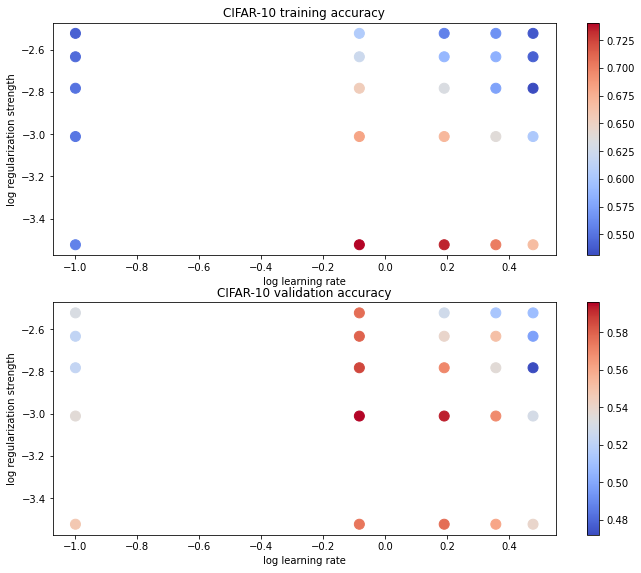

In [26]:
if len(valed_brs)*len(valed_hidden_sizes) == 1:

  # LCB FROM SVM.IPYNB # Visualize the cross-validation results
  import math
  import pdb

  # pdb.set_trace()

  x_scatter = [math.log10(x[0]) for x in results]
  y_scatter = [math.log10(x[1]) for x in results]

  # plot training accuracy
  marker_size = 100
  colors = [results[x][0] for x in results]
  plt.subplot(2, 1, 1)
  plt.tight_layout(pad=3)
  plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
  plt.colorbar()
  plt.xlabel('log learning rate')
  plt.ylabel('log regularization strength')
  plt.title('CIFAR-10 training accuracy')

  # plot validation accuracy
  colors = [results[x][1] for x in results] # default size of markers is 20
  plt.subplot(2, 1, 2)
  plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
  plt.colorbar()
  plt.xlabel('log learning rate')
  plt.ylabel('log regularization strength')
  plt.title('CIFAR-10 validation accuracy')
  plt.show()

---
# IMPORTANT

This is the end of this question. Please do the following:

1. Click `File -> Save` to make sure the latest checkpoint of this notebook is saved to your Drive.
2. Execute the cell below to download the modified `.py` files back to your drive.

In [ ]:
import os

FOLDER_TO_SAVE = os.path.join('drive/My Drive/', FOLDERNAME)
FILES_TO_SAVE = []

#for files in FILES_TO_SAVE:
#  with open(os.path.join(FOLDER_TO_SAVE, '/'.join(files.split('/')[1:])), 'w') as f:
#    f.write(''.join(open(files).readlines()))